# Semi-supervised Node Classification on Molecular Structures

## Model Definition

In [1]:
import dgl
import torch 
from torch import nn
import torch.nn.functional as F
import dgl.nn as gnn
import os 
from torchviz import make_dot
import numpy as np 

os.environ.setdefault('DGLBACKEND','pytorch')


def print_count_parameters(model):
    tot = 0
    for name, param in model.named_parameters():
        print(name, param.shape,param.numel())
        tot += param.numel()
    print('Total number of params:', tot)

### SAGE

In [2]:
class MyGNN(nn.Module):
    def __init__(self, 
                 num_node_types, 
                 embed_dim,
                 conv_dims, 
                 ):
        
        super(MyGNN, self).__init__()
        self.embedding = nn.Embedding(num_node_types,embed_dim)
        self.convs = nn.Sequential()
        last_hidden_dim = embed_dim

        for dim in conv_dims:
            self.convs.append(gnn.SAGEConv(last_hidden_dim,dim,aggregator_type='mean'))
            last_hidden_dim = dim

    def forward(self, g, in_feat):
        h = self.embedding(in_feat)
        for layer in self.convs: 
            h = layer(g, h)            
            h = F.relu(h)
        
        return h
    
class MySAGEClassifier(nn.Module):
    def __init__(self, 
                 num_node_types, 
                 embed_dim,
                 conv_dims, 
                 ):
        
        super(MySAGEClassifier, self).__init__()
        self.gnn = MyGNN(
                 num_node_types, 
                 embed_dim,
                 conv_dims,
                 )
        
        self.predictor =  gnn.SAGEConv(conv_dims[-1],num_node_types,aggregator_type='mean')
        
    def forward(self, g, in_feat):
        h = self.gnn(g,in_feat)
        h = self.predictor(g,h)
        h = F.softmax(h,dim=1)
        return h

gnn.embedding.weight torch.Size([93, 128]) 11904
gnn.convs.0.fc_neigh.weight torch.Size([256, 128]) 32768
gnn.convs.0.fc_self.weight torch.Size([256, 128]) 32768
gnn.convs.0.fc_self.bias torch.Size([256]) 256
gnn.convs.1.fc_neigh.weight torch.Size([512, 256]) 131072
gnn.convs.1.fc_self.weight torch.Size([512, 256]) 131072
gnn.convs.1.fc_self.bias torch.Size([512]) 512
gnn.convs.2.fc_neigh.weight torch.Size([1024, 512]) 524288
gnn.convs.2.fc_self.weight torch.Size([1024, 512]) 524288
gnn.convs.2.fc_self.bias torch.Size([1024]) 1024
predictor.fc_neigh.weight torch.Size([93, 1024]) 95232
predictor.fc_self.weight torch.Size([93, 1024]) 95232
predictor.fc_self.bias torch.Size([93]) 93
Total number of params: 1580509


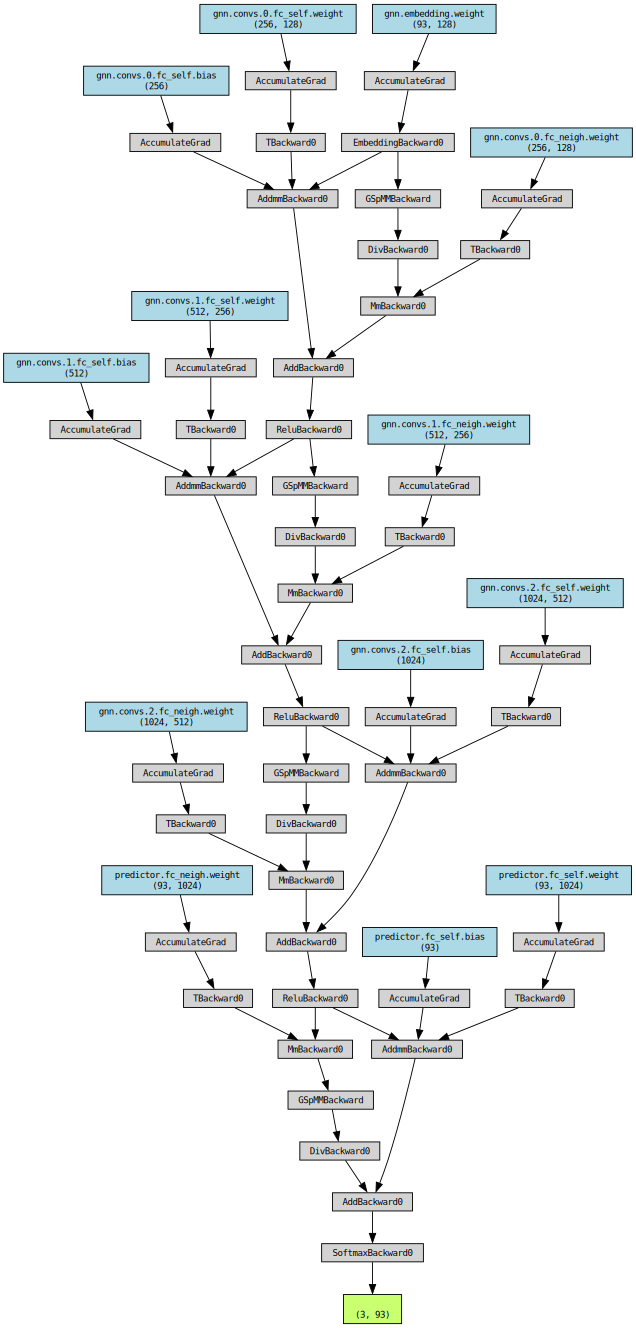

In [3]:
num_node_types = 93# 92 elements of the periodic table + a special type for masked nodes
embed_dim = 128
conv_dims = [256,512,1024]

model = MySAGEClassifier(num_node_types,embed_dim,conv_dims)
g = dgl.rand_graph(num_nodes=3,num_edges=6)
yhat = model(g, torch.randint(0,num_node_types,(g.num_nodes(),),dtype=torch.long))

print_count_parameters(model)
make_dot(yhat, params=dict(list(model.named_parameters())))

### GAT

In [4]:

"""
GAT 
Graph Attention Network, Attention convolution as described in  "Graph Attention Networks ()"
"""

class MyGAT(nn.Module):
    def __init__(self, 
                 num_node_types, 
                 embed_dim,
                 attn_dims, 
                 attn_heads,
                 activation = F.elu, 
                 ):
        
        super(MyGAT, self).__init__()
        self.embedding = nn.Embedding(num_node_types,embed_dim)
        self.convs = nn.Sequential()
        self.activation = activation
        
        assert len(attn_dims)==len(attn_heads)
        last_hidden_dim = embed_dim
        for i,dim in enumerate(attn_dims):
            self.convs.append(gnn.GATv2Conv(last_hidden_dim,dim,attn_heads[i]))
            last_hidden_dim = dim*attn_heads[i]

    def forward(self, g, in_feat):
        h = self.embedding(in_feat)
        for layer in self.convs: 
            h = layer(g,h).view(g.num_nodes(),-1)         
            h = self.activation(h)
        
        return h
    
class MyGATClassifier(nn.Module):
    def __init__(self, 
                num_node_types, 
                embed_dim,
                attn_dims, 
                attn_heads,
                classifier_attn_heads,
                ):
        
        super(MyGATClassifier, self).__init__()
        self.gat = MyGAT(num_node_types,embed_dim, attn_dims,attn_heads)
        self.classifier = gnn.GATConv(attn_dims[-1]*attn_heads[-1],num_node_types,classifier_attn_heads)
        

    def forward(self, g, in_feat):
        h = self.gat(g,in_feat)
        h = self.classifier(g,h)
        h = h.mean(dim=1)
        return F.softmax(h,dim=1)

gat.embedding.weight torch.Size([93, 16]) 1488
gat.convs.0.attn torch.Size([1, 8, 16]) 128
gat.convs.0.fc_src.weight torch.Size([128, 16]) 2048
gat.convs.0.fc_src.bias torch.Size([128]) 128
gat.convs.0.fc_dst.weight torch.Size([128, 16]) 2048
gat.convs.0.fc_dst.bias torch.Size([128]) 128
gat.convs.1.attn torch.Size([1, 16, 32]) 512
gat.convs.1.fc_src.weight torch.Size([512, 128]) 65536
gat.convs.1.fc_src.bias torch.Size([512]) 512
gat.convs.1.fc_dst.weight torch.Size([512, 128]) 65536
gat.convs.1.fc_dst.bias torch.Size([512]) 512
classifier.attn_l torch.Size([1, 8, 93]) 744
classifier.attn_r torch.Size([1, 8, 93]) 744
classifier.bias torch.Size([744]) 744
classifier.fc.weight torch.Size([744, 512]) 380928
Total number of params: 521736


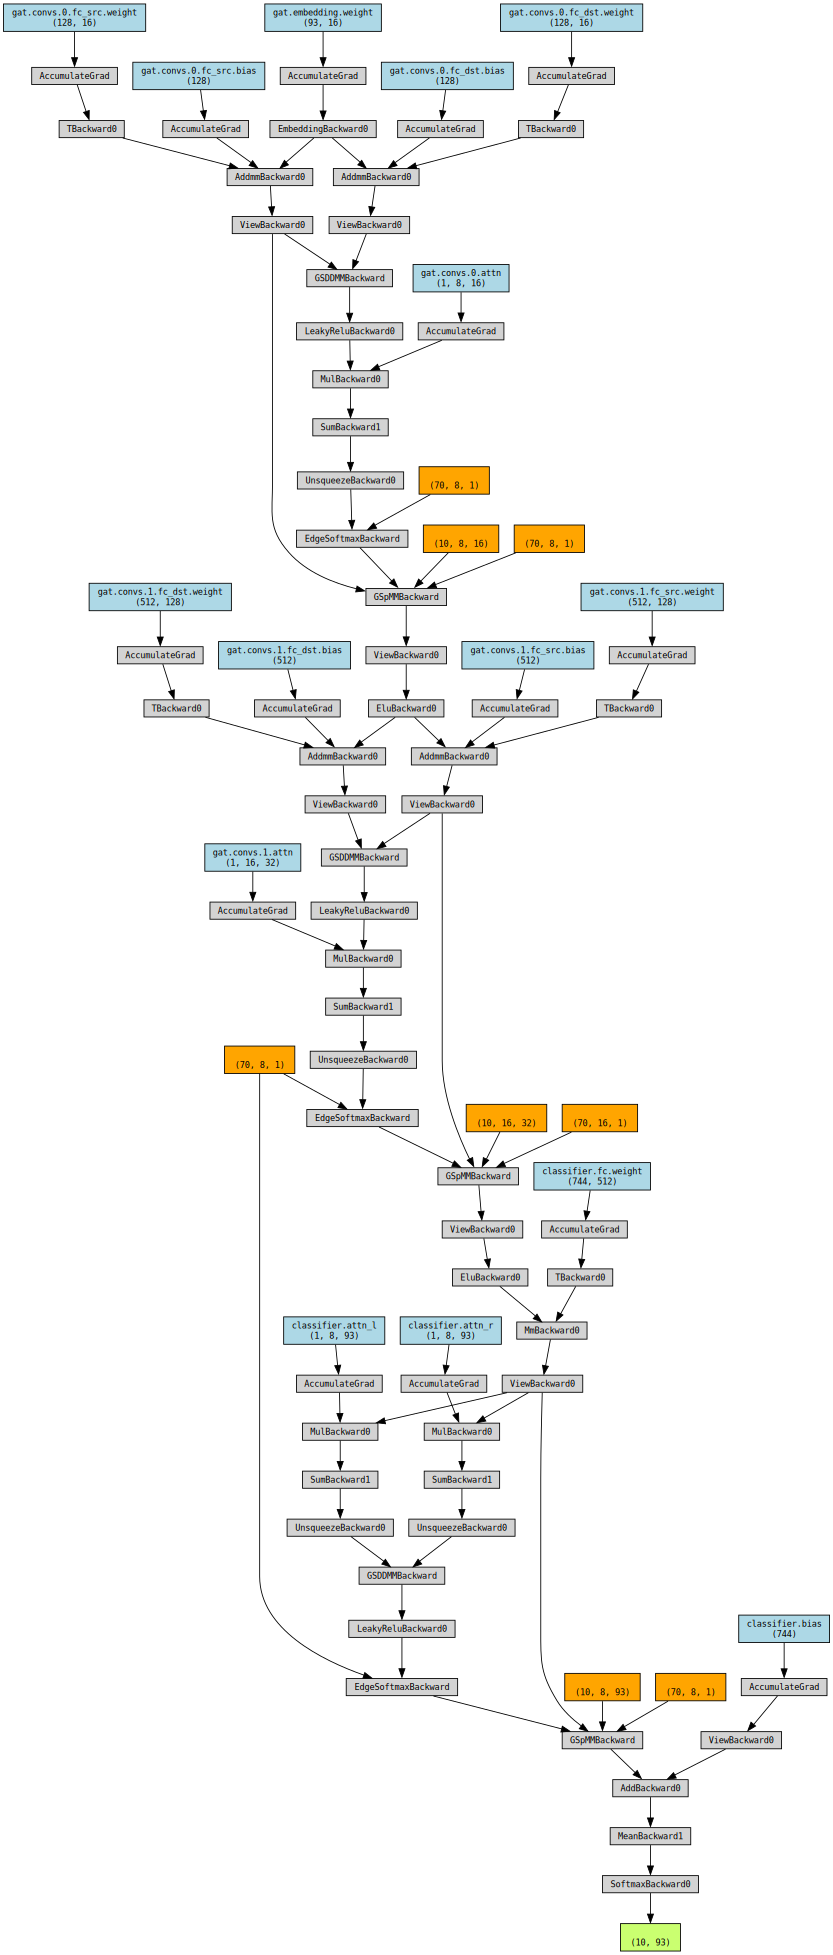

In [5]:
num_node_types = 93 # 92 elements of the periodic table + a special type for masked nodes
node_embed_dim = 16
attn_dims = [16,32]
attn_heads = [8,16]
classifier_attn_heads = 8

model = MyGATClassifier(num_node_types,node_embed_dim,attn_dims,attn_heads,classifier_attn_heads)
g = dgl.rand_graph(num_nodes=10,num_edges=70)
yhat = model(g, torch.randint(0,num_node_types,(g.num_nodes(),),dtype=torch.long))

print_count_parameters(model)
make_dot(yhat, params=dict(list(model.named_parameters())))

### EGAT

In [6]:

"""
EGAT
Graph Attention Network with edge features
"""
class MyEGAT(nn.Module):
    def __init__(self, 
                 num_node_types, 
                 node_embed_dim,
                 edge_embed_dim,
                 edge_dims,
                 attn_dims, 
                 attn_heads,
                 activation = F.elu, 
                 ):
        
        super(MyEGAT, self).__init__()
        self.embedding = nn.Embedding(num_node_types,node_embed_dim)
        self.convs = nn.Sequential()
        self.activation = activation
        
        assert len(attn_dims)==len(attn_heads)
        last_hidden_dim = node_embed_dim
        last_edge_dim = edge_embed_dim
    
        for i,out_dim in enumerate(attn_dims):
            self.convs.append(gnn.EGATConv(last_hidden_dim,last_edge_dim,out_dim,edge_dims[i],attn_heads[i]))
            last_hidden_dim = out_dim*attn_heads[i]
            last_edge_dim = edge_dims[i]*attn_heads[i]

    def forward(self, g, nfeats, efeats):
        nfeats = self.embedding(nfeats)
        for layer in self.convs: 
            nfeats,efeats = layer(g,nfeats,efeats) 
            nfeats = self.activation(nfeats.view(g.num_nodes(),-1))
            efeats = self.activation(efeats.view(g.num_edges(),-1))    

        return nfeats,efeats
    
class MyEGATClassifier(nn.Module):
    def __init__(self, 
                num_node_types, 
                node_embed_dim,
                edge_embed_dim,
                edge_dims,
                attn_dims, 
                attn_heads,
                classifier_attn_heads,
                ):
        
        super(MyEGATClassifier, self).__init__()
        self.gat = MyEGAT(num_node_types,node_embed_dim,edge_embed_dim,edge_dims,attn_dims,attn_heads)
        self.classifier = gnn.EGATConv(attn_dims[-1]*attn_heads[-1],edge_dims[-1]*attn_heads[-1],num_node_types,1,classifier_attn_heads)
        

    def forward(self, g, nfeats,efeats):
        node_feats,edge_feats = self.gat(g,nfeats,efeats)
        out_feats,_ = self.classifier(g,node_feats,edge_feats)
        out_feats = out_feats.mean(dim=1)
        return F.softmax(out_feats,dim=1)

gat.embedding.weight torch.Size([93, 16]) 1488
gat.convs.0.attn torch.Size([1, 8, 4]) 32
gat.convs.0.bias torch.Size([32]) 32
gat.convs.0.fc_node_src.weight torch.Size([128, 16]) 2048
gat.convs.0.fc_ni.weight torch.Size([32, 16]) 512
gat.convs.0.fc_nj.weight torch.Size([32, 16]) 512
gat.convs.0.fc_fij.weight torch.Size([32, 100]) 3200
gat.convs.1.attn torch.Size([1, 16, 16]) 256
gat.convs.1.bias torch.Size([256]) 256
gat.convs.1.fc_node_src.weight torch.Size([512, 128]) 65536
gat.convs.1.fc_ni.weight torch.Size([256, 128]) 32768
gat.convs.1.fc_nj.weight torch.Size([256, 128]) 32768
gat.convs.1.fc_fij.weight torch.Size([256, 32]) 8192
classifier.attn torch.Size([1, 8, 1]) 8
classifier.bias torch.Size([8]) 8
classifier.fc_node_src.weight torch.Size([744, 512]) 380928
classifier.fc_ni.weight torch.Size([8, 512]) 4096
classifier.fc_nj.weight torch.Size([8, 512]) 4096
classifier.fc_fij.weight torch.Size([8, 256]) 2048
Total number of params: 538784


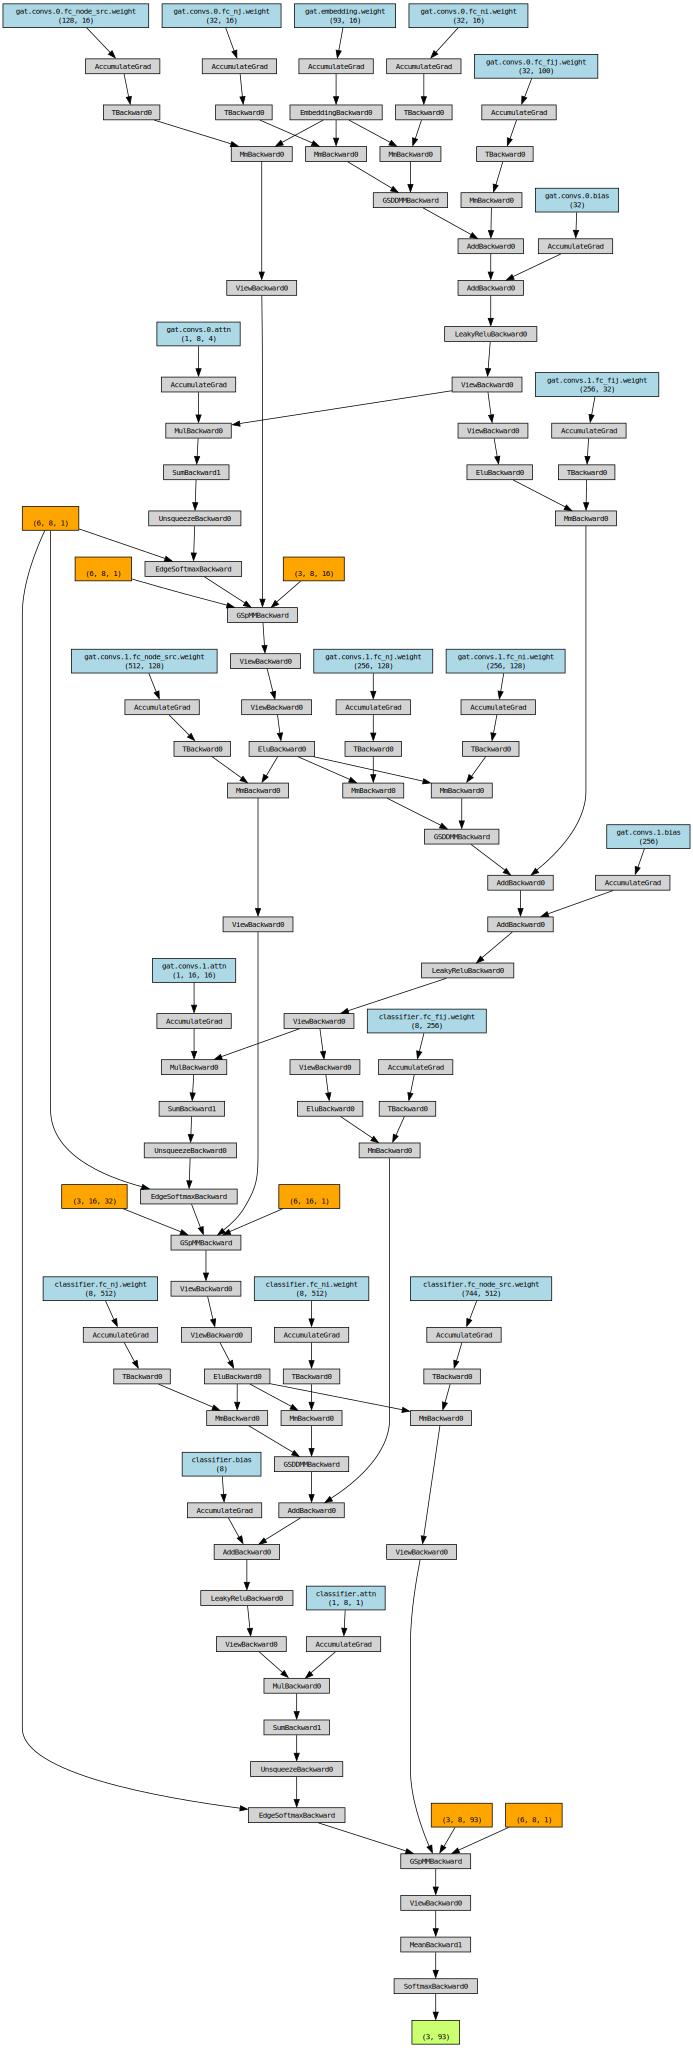

In [7]:
num_node_types = 93 # 92 elements of the periodic table + a special type for masked nodes
node_embed_dim = 16
edge_embed_dim = 100
edge_dims = [4,16] 
attn_dims = [16,32]
attn_heads = [8,16]
classifier_attn_heads = 8

model = MyEGATClassifier(num_node_types,node_embed_dim,edge_embed_dim,edge_dims,attn_dims,attn_heads,classifier_attn_heads)
g = dgl.rand_graph(num_nodes=3,num_edges=6)
yhat = model(g, torch.randint(0,num_node_types,(g.num_nodes(),),dtype=torch.long),torch.rand((g.num_edges(),edge_embed_dim)))

print_count_parameters(model)
make_dot(yhat, params=dict(list(model.named_parameters())))

### M-MEGNet

In [8]:
import dgl
import torch
from dgl.nn import Set2Set
from torch import nn

from matgl.config import DEFAULT_ELEMENT_TYPES
from matgl.graph.compute import compute_pair_vector_and_distance
from matgl.graph.converters import GraphConverter
from matgl.layers import MLP, BondExpansion, EdgeSet2Set, EmbeddingBlock, MEGNetBlock, SoftExponential, SoftPlus2

class MMEGNet(nn.Module):
    """
    DGL implementation of MEGNet.
    """

    def __init__(
        self,
        dim_node_embedding: int = 16,
        dim_edge_embedding: int = 100,
        dim_state_embedding: int = 2,
        nblocks: int = 3,
        hidden_layer_sizes_input: tuple[int, ...] = (64, 32),
        hidden_layer_sizes_conv: tuple[int, ...] = (64, 64, 32),
        hidden_layer_sizes_output: tuple[int, ...] = (32, 16),
        nlayers_set2set: int = 1,
        niters_set2set: int = 2,
        activation_type: str = "softplus2",
        is_classification: bool = False,
        layer_node_embedding: nn.Module | None = None,
        layer_edge_embedding: nn.Module | None = None,
        layer_state_embedding: nn.Module | None = None,
        include_state_embedding: bool = False,
        dropout: float | None = None,
        graph_transformations: list | None = None,
        element_types: tuple[str, ...] | None = None,
        data_mean: torch.Tensor | None = None,
        data_std: torch.Tensor | None = None,
        bond_expansion: BondExpansion | None = None,
        cutoff: float = 4.0,
        gauss_width: float = 0.5,
        **kwargs,
    ):
        """
        Construct a MEGNet model. Useful defaults for all arguments have been specified based on MEGNet formation energy
        model.

        Args:
            dim_node_embedding: Dimension of node embedding.
            dim_edge_embedding: Dimension of edge embedding.
            dim_state_embedding: Dimension of state embedding.
            nblocks: Number of blocks.
            hidden_layer_sizes_input: Architecture of dense layers before the graph convolution
            hidden_layer_sizes_conv: Architecture of dense layers for message and update functions
            nlayers_set2set: Number of layers in Set2Set layer
            niters_set2set: Number of iteratons in Set2Set layer
            hidden_layer_sizes_output: Architecture of dense layers for concatenated features after graph convolution
            activation_types: Activation used for non-linearity
            is_classification: Whether this is classification task or not
            layer_node_embedding: Architecture of embedding layer for node attributes
            layer_edge_embedding: Architecture of embedding layer for edge attributes
            layer_state_embedding: Architecture of embedding layer for state attributes
            include_state_embedding: Whether the state embedding is included
            dropout: Randomly zeroes some elements in the input tensor with given probability (0 < x < 1) according to
                a Bernoulli distribution
            graph_transformations: Perform a graph transformation, e.g., incorporate three-body interactions, prior to
                performing the GCL updates.
            element_types: Elements included in the training set
            data_mean: Mean of target properties in the training set. Defaults to 0.
            data_std: Standard deviation of target properties in the training set. Defaults to 1.
            bond_expansion: Gaussian expansion for edge attributes
            cutoff: cutoff for forming bonds
            gauss_width: width of Gaussian function for bond expansion
            **kwargs:
        """
        # Store MEGNet model args for loading trained model
        self.model_args = {k: v for k, v in locals().items() if k not in ["self", "__class__", "kwargs"]}
        self.model_args.update(kwargs)

        super().__init__()

        self.element_types = element_types or DEFAULT_ELEMENT_TYPES
        self.cutoff = cutoff
        self.bond_expansion = bond_expansion or BondExpansion(
            rbf_type="Gaussian", initial=0.0, final=cutoff + 1.0, num_centers=dim_edge_embedding, width=gauss_width
        )
        self.data_mean = data_mean or torch.zeros(1)
        self.data_std = data_std or torch.ones(1)

        self.layer_edge_embedding = layer_edge_embedding if layer_edge_embedding else nn.Identity()
        if layer_node_embedding is None:
            self.layer_node_embedding = nn.Embedding(len(self.element_types), dim_node_embedding)
        else:
            self.layer_node_embedding = layer_node_embedding
        self.layer_state_embedding = layer_state_embedding or nn.Identity()

        node_dims = [dim_node_embedding, *hidden_layer_sizes_input]
        edge_dims = [dim_edge_embedding, *hidden_layer_sizes_input]
        state_dims = [dim_state_embedding, *hidden_layer_sizes_input]

        if activation_type == "swish":
            activation = nn.SiLU()  # type: ignore
        elif activation_type == "sigmoid":
            activation = nn.Sigmoid()  # type: ignore
        elif activation_type == "tanh":
            activation = nn.Tanh()  # type: ignore
        elif activation_type == "softplus2":
            activation = SoftPlus2()  # type: ignore
        elif activation_type == "softexp":
            activation = SoftExponential()  # type: ignore
        else:
            raise Exception("Undefined activation type, please try using swish, sigmoid, tanh, softplus2, softexp")

        self.edge_encoder = MLP(edge_dims, activation, activate_last=True)
        self.node_encoder = MLP(node_dims, activation, activate_last=True)
        self.state_encoder = MLP(state_dims, activation, activate_last=True)

        dim_blocks_in = hidden_layer_sizes_input[-1]
        dim_blocks_out = hidden_layer_sizes_conv[-1]
        block_args = {
            "conv_hiddens": hidden_layer_sizes_conv,
            "dropout": dropout,
            "act": activation,
            "skip": True,
        }
        # first block
        blocks = [MEGNetBlock(dims=[dim_blocks_in], **block_args)]  # type: ignore
        # other blocks
        for _ in range(nblocks - 1):
            blocks.append(MEGNetBlock(dims=[dim_blocks_out, *hidden_layer_sizes_input], **block_args))  # type: ignore
        self.blocks = nn.ModuleList(blocks)


        self.dim_blocks_out = dim_blocks_out
        self.activation = activation 

        # self.output_proj = MLP(
        #     dims=[2 * 2 * dim_blocks_out + dim_blocks_out, *hidden_layer_sizes_output, 1],
        #     activation=activation,
        #     activate_last=False,
        # )

        self.graph_transformations = graph_transformations or [nn.Identity()] * nblocks
        self.include_state_embedding = include_state_embedding
        self.hidden_layer_sizes_output = hidden_layer_sizes_output
    
    def forward(
        self,
        graph: dgl.DGLGraph,
        edge_feat: torch.Tensor,
        node_feat: torch.Tensor,
        state_feat: torch.Tensor,
    ):
        """
        Forward pass of MEGnet. Executes all blocks.

        :param graph: Input graph
        :param edge_feat: Edge features
        :param node_feat: Node features
        :param state_feat: State features.
        :return: Prediction
        """
        graph_transformations = self.graph_transformations
        edge_feat = self.edge_encoder(self.layer_edge_embedding(edge_feat))
        node_feat = self.node_encoder(self.layer_node_embedding(node_feat))
        if self.include_state_embedding:
            state_feat = self.state_encoder(self.layer_state_embedding(state_feat))
        else:
            state_feat = self.state_encoder(state_feat)

        for gt, block in zip(graph_transformations, self.blocks):
            output = block(gt(graph), edge_feat, node_feat, state_feat)
            edge_feat, node_feat, state_feat = output

        state_feat = torch.squeeze(state_feat)

        return node_feat,edge_feat,state_feat

class MMEGNetClassifier(nn.Module):
    """
    DGL implementation of MEGNet.
    """

    def __init__(
        self,
        **megnet_args,
    ):
        super(MMEGNetClassifier,self).__init__()
        self.megnet = MMEGNet(**megnet_args)
        self.fc = nn.Linear(32,1)

        
        
        self.output_proj = MLP(
            dims=[self.megnet.dim_blocks_out, *self.megnet.hidden_layer_sizes_output, 1],
            activation=self.megnet.activation,
            activate_last=False,
        )

    def forward(
        self,
        graph: dgl.DGLGraph,
        edge_feat: torch.Tensor,
        node_feat: torch.Tensor,
        state_feat: torch.Tensor,
    ):
        node_vec,_,_ = self.megnet(graph,edge_feat,node_feat,state_feat)
        return torch.sigmoid(self.output_proj(node_vec))
model = MMEGNetClassifier()
g = dgl.rand_graph(num_nodes=3,num_edges=6)
node_feat = torch.randint(0,num_node_types,(g.num_nodes(),),dtype=torch.long)
edge_feat = torch.rand((g.num_edges(),100))
state_feat = torch.zeros(2)
print_count_parameters(model)

yhat = model(g,edge_feat,node_feat,state_feat)
yhat.shape

megnet.bond_expansion.rbf.centers torch.Size([100]) 100
megnet.layer_node_embedding.weight torch.Size([89, 16]) 1424
megnet.edge_encoder.layers.0.weight torch.Size([64, 100]) 6400
megnet.edge_encoder.layers.0.bias torch.Size([64]) 64
megnet.edge_encoder.layers.2.weight torch.Size([32, 64]) 2048
megnet.edge_encoder.layers.2.bias torch.Size([32]) 32
megnet.node_encoder.layers.0.weight torch.Size([64, 16]) 1024
megnet.node_encoder.layers.0.bias torch.Size([64]) 64
megnet.node_encoder.layers.2.weight torch.Size([32, 64]) 2048
megnet.node_encoder.layers.2.bias torch.Size([32]) 32
megnet.state_encoder.layers.0.weight torch.Size([64, 2]) 128
megnet.state_encoder.layers.0.bias torch.Size([64]) 64
megnet.state_encoder.layers.2.weight torch.Size([32, 64]) 2048
megnet.state_encoder.layers.2.bias torch.Size([32]) 32
megnet.blocks.0.conv.edge_func.layers.0.weight torch.Size([64, 128]) 8192
megnet.blocks.0.conv.edge_func.layers.0.bias torch.Size([64]) 64
megnet.blocks.0.conv.edge_func.layers.2.weigh

c:\Users\tomma\Documents\Uni\Magistrale\pyvenvs\ML_venv\lib\site-packages\dgl\readout.py:443: DGLWarning: For a single graph, use a tensor of shape (1, *) for graph_feat. The support of shape (*) will be deprecated.
  dgl_warning(


torch.Size([3, 1])

In [9]:
model = MMEGNetClassifier()
g = dgl.rand_graph(num_nodes=3,num_edges=6)
node_feat = torch.randint(0,num_node_types,(g.num_nodes(),),dtype=torch.long)
edge_feat = torch.rand((g.num_edges(),100))
state_feat = torch.zeros(2)
print_count_parameters(model)

yhat = model(g,edge_feat,node_feat,state_feat)
yhat.shape

megnet.bond_expansion.rbf.centers torch.Size([100]) 100
megnet.layer_node_embedding.weight torch.Size([89, 16]) 1424
megnet.edge_encoder.layers.0.weight torch.Size([64, 100]) 6400
megnet.edge_encoder.layers.0.bias torch.Size([64]) 64
megnet.edge_encoder.layers.2.weight torch.Size([32, 64]) 2048
megnet.edge_encoder.layers.2.bias torch.Size([32]) 32
megnet.node_encoder.layers.0.weight torch.Size([64, 16]) 1024
megnet.node_encoder.layers.0.bias torch.Size([64]) 64
megnet.node_encoder.layers.2.weight torch.Size([32, 64]) 2048
megnet.node_encoder.layers.2.bias torch.Size([32]) 32
megnet.state_encoder.layers.0.weight torch.Size([64, 2]) 128
megnet.state_encoder.layers.0.bias torch.Size([64]) 64
megnet.state_encoder.layers.2.weight torch.Size([32, 64]) 2048
megnet.state_encoder.layers.2.bias torch.Size([32]) 32
megnet.blocks.0.conv.edge_func.layers.0.weight torch.Size([64, 128]) 8192
megnet.blocks.0.conv.edge_func.layers.0.bias torch.Size([64]) 64
megnet.blocks.0.conv.edge_func.layers.2.weigh

torch.Size([3, 1])

## Training Loop Definition

In [10]:
import json
import logging
import os
import shutil
from timeit import default_timer
from tqdm.notebook import tqdm 
import numpy as np 
from sklearn.utils import resample

logger = logging.getLogger("GNN_trainer")

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def mask_labels(labels, sample_frac=0.2):
    mask = torch.rand(len(labels),device=labels.device) < sample_frac
    return labels * ~mask, mask 


def train_one_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_function: nn.Module,
    dataloader: tuple,
    device: torch.cuda.device | str = 'cuda',
):
    model.train()
    
    total_num_atoms = 0
    avg_acc = 0
    avg_loss = torch.zeros(1)

    start = default_timer()    

    for g  in tqdm(dataloader):
        optimizer.zero_grad()
        
        g = g.to(device)
        node_types = g.ndata["node_type"].long()
        # edge_feat = g.edata['bond_dist'].unsqueeze(1)
        edge_feat = g.edata['bond_dist_exp'].unsqueeze(1)
        node_feat,mask = mask_labels(node_types)

        # Forward pass
        logits = model(g, node_feat,edge_feat)

        # Compute loss
        loss = loss_function(logits[mask], node_types[mask])

        # Compute prediction
        pred = logits.argmax(1)
        acc = (pred[mask] == node_types[mask]).float().mean()
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        num_atoms = mask.sum().item()
        avg_loss += loss.detach().cpu() * num_atoms
        avg_acc += acc * num_atoms
        total_num_atoms += num_atoms
    
        optimizer.zero_grad()


    stop = default_timer()

    avg_loss = avg_loss.cpu().item() / total_num_atoms
    avg_acc = avg_acc.cpu().item() / total_num_atoms
    epoch_time = stop - start


    return avg_loss, avg_acc, epoch_time

class StreamingJSONWriter:
    """
    Serialize streaming data to JSON.

    This class holds onto an open file reference to which it carefully
    appends new JSON data. Individual entries are input in a list, and
    after every entry the list is closed so that it remains valid JSON.
    When a new item is added, the file cursor is moved backwards to overwrite
    the list closing bracket.
    """

    def __init__(self, filename, encoder=json.JSONEncoder):
        if os.path.exists(filename):
            self.file = open(filename, "r+")
            self.delimeter = ","
        else:
            self.file = open(filename, "w")
            self.delimeter = "["
        self.encoder = encoder

    def dump(self, obj):
        """
        Dump a JSON-serializable object to file.
        """
        data = json.dumps(obj, cls=self.encoder)
        close_str = "\n]\n"
        self.file.seek(max(self.file.seek(0, os.SEEK_END) - len(close_str), 0))
        self.file.write(f"{self.delimeter}\n    {data}{close_str}")
        self.file.flush()
        self.delimeter = ","

    def close(self):
        self.file.close()


class MyTrainer:
    def __init__(self, 
                 model: nn.Module, 
                 optimizer: torch.optim.Optimizer, 
                 scheduler: torch.optim.lr_scheduler,
                es_patience: int,
                es_min_delta: float,) -> None:
        """
        Parameters:
        model: MEGNet model
        optimizer: torch Optimizer
        """
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.early_stopper = None
        if es_patience > 0 : 
             self.early_stopper = EarlyStopper(es_patience,es_min_delta)
        

    def train(
        self,
        num_epochs: int,
        train_loss_func: nn.Module,
        train_loader: tuple,
        logger_name: str,
        device: torch.cuda.device | str = 'cpu',
        path: str = None,
    ) -> None:
        
        if path is None: path = os.getcwd()

        # Set a path for best model and checkpoints
        outpath = os.path.join(path, "BestModel")
        checkpath = os.path.join(path, "CheckPoints")
        if os.path.exists(outpath):
            shutil.rmtree(outpath)
        os.mkdir(outpath)
        if os.path.exists(checkpath):
            shutil.rmtree(checkpath)
        os.mkdir(checkpath)
        jsonlog = StreamingJSONWriter(filename=logger_name)
        logger.info("## Training started ##")
        best_loss = np.inf
        for epoch in tqdm(range(num_epochs)):

            loss,acc, train_time = train_one_step(
                self.model,
                self.optimizer,
                train_loss_func,
                train_loader,
                device = device,
                )


            self.scheduler.step()
            logger.info(
                f"Epoch: {epoch + 1:03} Loss: {loss:.4f} Acc: {acc:.2f}"
            )

            if loss < best_loss:
                torch.save(
                    {
                        "epoch": epoch + 1,
                        "model": self.model.state_dict(),
                        "optimizer_state_dict": self.optimizer.state_dict(),
                        "scheduler_state_dict": self.scheduler.state_dict(),
                        "loss": loss,
                        "acc": acc,

                    },
                    checkpath + "/%05d" % (epoch + 1) + "-%6.5f" % (loss) + ".pt",
                )

                log_dict = {
                    "Epoch": epoch + 1,
                    "train_loss": loss,
                    "train_acc":acc,
                    "train_time": train_time,
                }

                jsonlog.dump(log_dict)
                best_loss = loss
                torch.save({"model": self.model.state_dict()}, outpath + "/best-model.pt")

            if self.early_stopper is not None and self.early_stopper.early_stop(validation_loss=loss):
                            tqdm.write('Early Stopping')
                            break
            tqdm.write(f'Epoch {epoch+1}/{num_epochs}\t Train Loss: {loss}, Train Acc: {acc}')
        jsonlog.close()
        logger.info("## Training complete ##")

class MyDataset(torch.utils.data.Dataset):
    def __init__(self,graphs):
        super(MyDataset).__init__()
        self.graphs = graphs
        
    def __getitem__(self,idx):
        return self.graphs[idx]
    
    def __len__(self):
        return len(self.graphs)

## Masked Molecular Modeling 

In [11]:
modeltype = 'EGAT' # 'GAT'

if modeltype == 'SAGE':     
    num_node_types = 93# 92 elements of the periodic table + a special type for masked nodes
    embed_dim = 128
    conv_dims = [256,512,1024]
    model = MySAGEClassifier(num_node_types,embed_dim,conv_dims)
elif modeltype == 'GAT': 
    num_node_types = 93
    embed_dim = 16
    attn_dims = [16,32]
    attn_heads = [8,16]
    classifier_attn_heads = 8
    model = MyGATClassifier(num_node_types,embed_dim,attn_dims,attn_heads,classifier_attn_heads)
elif modeltype == 'EGAT': 
    num_node_types = 93 # 92 elements of the periodic table + a special type for masked nodes
    node_embed_dim = 16
    edge_embed_dim = 1
    edge_dims = [4,16] 
    attn_dims = [16,32]
    attn_heads = [8,16]
    classifier_attn_heads = 8
    model = MyEGATClassifier(num_node_types,node_embed_dim,edge_embed_dim,edge_dims,attn_dims,attn_heads,classifier_attn_heads)

In [12]:
"""
# We are not gonna train the models here, this is just a demo notebook, but here is the code for completeness

graphs,target_dict= dgl.load_graphs('C:/Users/tomma/Documents/Uni/Magistrale/Internship/Code/data/QM9_graphs_simple.bin')
dataset = MyDataset(graphs)

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('Available device:',device)

model = model.to(device)


learning_rate = 1e-4 
num_epochs = 1
batch_size = 8
logger_name = f'out/{modeltype}/train.output'
logpath = f'out/{modeltype}'
es_patience = 10
es_min_delta=1e-4

optimizer = torch.optim.Adam((p for p in model.parameters()), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.1)

loss_func = nn.CrossEntropyLoss()
train_loader = dgl.dataloading.GraphDataLoader(MyDataset(graphs),batch_size=batch_size)

trainer = MyTrainer(model,optimizer,scheduler,es_patience,es_min_delta)
trainer.train(num_epochs,loss_func,train_loader,logger_name,device,logpath)
"""

"\n# We are not gonna train the models here, this is just a demo notebook, but here is the code for completeness\n\ngraphs,target_dict= dgl.load_graphs('C:/Users/tomma/Documents/Uni/Magistrale/Internship/Code/data/QM9_graphs_simple.bin')\ndataset = MyDataset(graphs)\n\ndevice = 'cpu'\nif torch.cuda.is_available():\n    device = 'cuda'\nprint('Available device:',device)\n\nmodel = model.to(device)\n\n\nlearning_rate = 1e-4 \nnum_epochs = 1\nbatch_size = 8\nlogger_name = f'out/{modeltype}/train.output'\nlogpath = f'out/{modeltype}'\nes_patience = 10\nes_min_delta=1e-4\n\noptimizer = torch.optim.Adam((p for p in model.parameters()), lr = learning_rate)\nscheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1,end_factor=0.1)\n\nloss_func = nn.CrossEntropyLoss()\ntrain_loader = dgl.dataloading.GraphDataLoader(MyDataset(graphs),batch_size=batch_size)\n\ntrainer = MyTrainer(model,optimizer,scheduler,es_patience,es_min_delta)\ntrainer.train(num_epochs,loss_func,train_loader,logg

# Other Stuff

In [13]:
import numpy as np
import dgl
import seaborn as sns 
import matplotlib.pyplot as plt
from matgl.layers._basis import GaussianExpansion
from tqdm.notebook import tqdm
import pymatgen.core as mg 
import py3Dmol
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display
from ipywidgets import Dropdown,Button, HBox, VBox
import matplotlib

In [41]:
def get_cmap():
    df_colors = pd.read_csv("https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv")

    colors = ['#000000']
    for i in range(1,95):
        atom = mg.Element.from_Z(i).name
        r = df_colors[df_colors['atom'] == atom]['R'].values[0]
        g = df_colors[df_colors['atom'] == atom]['G'].values[0]
        b = df_colors[df_colors['atom'] == atom]['B'].values[0]
        colors.append('#{:02x}{:02x}{:02x}'.format(r, g, b))

    cmap = LinearSegmentedColormap.from_list('Atoms',colors)
    return colors, cmap

colors, cmap = get_cmap()

def plot_graph(g,attention=None,title='',ax=None, mask = None, predictions = None):

    if ax is None:
        fig = plt.figure(figsize=(7,7))
        ax  = fig.add_subplot(projection='3d',title=title)
    else: ax.set_title(title)
    positions = g.ndata['pos']
    atomic_numbers = g.ndata['node_type']
    edges_src,edges_dst= g.edges()

    scatter = ax.scatter(positions[:,0],positions[:,1],positions[:,2],s=atomic_numbers*10,c=atomic_numbers,cmap = cmap, vmin=0, vmax=len(colors))

    if mask is not None: 
        ax.scatter(positions[mask,0],positions[mask,1],positions[mask,2],
                   s=atomic_numbers[mask]*15,
                   facecolors='none', 
                   edgecolors='gray',
                   linewidths=3.0,
                   alpha=0.5)
        if predictions is not None: 
            right = (atomic_numbers == predictions)
            wrong = mask & ~right 
            right = mask & right 
            

            ax.scatter(positions[right,0],positions[right,1],positions[right,2],s=atomic_numbers[right]*20,facecolors='none', edgecolors='green',linewidths=3.0)
            ax.scatter(positions[wrong,0],positions[wrong,1],positions[wrong,2],s=atomic_numbers[wrong]*20,facecolors='none', edgecolors='red',linewidths=3.0)

    a = scatter.legend_elements()
    legend1 = ax.legend(a[0],[mg.Element.from_Z(int(s[14:-2])).name for s in a[1]],loc="lower left", title="Element Types")
    ax.add_artist(legend1)
    for i,(src,dst) in enumerate(zip(edges_src,edges_dst)):
        sx ,sy, sz = positions[src]
        dx ,dy, dz = positions[dst]
        lx,ly,lz =np.linspace(sx,dx,10),np.linspace(sy,dy,10),np.linspace(sz,dz,10)
        ax.plot(lx,ly,lz, c='black', alpha = 0.5 if attention is None else attention[i])
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('c')
    return ax


def graph2xyz(graph):
    return f"{graph.num_nodes()}\n\n"+\
            "\n".join([f"{mg.Element.from_Z(graph.ndata['node_type'][i]).name} {graph.ndata['pos'][i][0]} {graph.ndata['pos'][i][1]} {graph.ndata['pos'][i][2]}" 
                       for i in range(graph.num_nodes())])

def getView(graph):
    #First we assign the py3Dmol.view as view
    view=py3Dmol.view()
    #The following lines are used to add the addModel class
    #to read the PDB files of chain B and C
    view.addModel(graph2xyz(graph),'xyz',{'bondLength':0.5})

    #Here we set the background color as white
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    # view.setStyle({'chain':'A'},{"stick": {'color': 'black'}})
    view.setStyle({'stick': {'opacity':0.6 , 'radius':0.05,'color':'black'}})

    for i in range(graph.num_nodes()):
        atom_line = 'H {:f} {:f} {:f}\n'.format( *graph.ndata['pos'][i])
        atom_model = '1\n\n' + atom_line
        view.addModel(atom_model, 'xyz')
        # color = get_color_based_on_atom_type(graph.ndata['node_type'][i],0,7)
        node_type = graph.ndata['node_type'][i].item()
        # color = get_color(mg.Element.from_Z(node_type).name)
        color = colors[node_type]

        view.setStyle({'model': -1}, 
                      {'sphere': {'color': color, 'radius':node_type/40}},)

    #Zooming into all visualized structures 
    view.zoomTo()

    return view

In [59]:
def compute_attentions(model,g,nfeats,efeats):
    attentions = []
    nfeats = model.gat.embedding(nfeats)
    for layer in model.gat.convs: 
        nfeats,efeats,attn = layer(g,nfeats,efeats,get_attention=True)#.view(g.num_nodes(),-1)    
        nfeats = model.gat.activation(nfeats.view(g.num_nodes(),-1))
        efeats = model.gat.activation(efeats.view(g.num_edges(),-1))    
        attentions.append(attn)

    out_feats,_,attn = model.classifier(g,nfeats,efeats,get_attention=True)
    out_feats = out_feats.mean(dim=1)
    attentions.append(attn)
    return F.softmax(out_feats,dim=1),attentions


def display_selector(g,attns,name='',mask=None,predictions=None):

    is_matplotlib_inline = matplotlib.get_backend()=="module://matplotlib_inline.backend_inline"
    # Create the list of plots
    plots = []
    plot_idx = 0

    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            plots.append((f'att{i}_{j}',att))

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111,projection='3d')

    # Create the dropdown widget and buttons
    dropdown_plot_selector = Dropdown(options=[plot[0] for plot in plots])
    prevButton = Button(description="<")
    nextButton = Button(description=">")
    # Display them
    box = HBox([prevButton,dropdown_plot_selector,nextButton])
    display.display(box)

    # Workaround to dinamically show plots when inline
    if is_matplotlib_inline:
        hdisplay_img = display.display(display_id=True)
        plt.close()

    def plot_selector(change):
        nonlocal plot_idx,prevButton,nextButton
        selected_plot = dropdown_plot_selector.value
        for i,(title,att) in enumerate(plots):
            if title == selected_plot: 
                ax.clear()
                if name: title = name +" - " + title
                plot_graph(g.cpu(),attention=att.numpy(),title=title,mask=mask, predictions=predictions,ax=ax)
                plot_idx = i
                if is_matplotlib_inline:
                    hdisplay_img.update(fig)
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1

    def swipe(backward = False):
        nonlocal plot_idx,prevButton,nextButton
        if not backward: 
            if 0 < len(plots)-1:
                 plot_idx += 1
        elif plot_idx > 0: 
            plot_idx -= 1
        prevButton.disabled = plot_idx == 0
        nextButton.disabled = plot_idx == len(plots)-1
        dropdown_plot_selector.value = plots[plot_idx][0]
        dropdown_plot_selector.selected_label = plots[plot_idx][0]
        plot_selector(None)

    dropdown_plot_selector.observe(plot_selector, names='value')
    prevButton.on_click(lambda x : swipe(backward = True))
    nextButton.on_click(lambda x : swipe(backward = False))
    prevButton.disabled = True


    plot_selector(None)
    return

def display_attn_grid(g,attns,prefix = None, mask = None,preds = None):
    fig,axs = plt.subplots(3,8,subplot_kw={'projection':'3d'})
    fig.set_size_inches(25,12)
    for i,atts in enumerate(attns): 
        for j in range(atts.shape[1]):
            att = atts[:,j].squeeze()
            if prefix is not None: title = f'{prefix} - att{i}_{j}'
            else: title = f'att{i}_{j}'
            plot_graph(g,attention=att.numpy(),title=title,mask = mask, predictions = preds,ax=axs[i,j])
            
            axs[i,j].get_legend().set_visible(False)
    lines = axs[0,0].get_legend().get_lines()
    texts = [e.get_text() for e in axs[0,0].get_legend().get_texts()]
    fig.legend(lines,texts,loc='upper center', ncol=8)
    plt.tight_layout()
    plt.show()

def accuracy_report(labels,preds):
    print("accuracy:",accuracy_score(labels,preds))

    labels_unique = np.unique(labels)
    f1 = f1_score(labels,preds,average=None)
    print("f1_score:")
    for i, label in enumerate(labels_unique):
        print(f'\t{mg.Element.from_Z(label).name}: {f1[i]}')
    print("\tavg(macro):", f1_score(labels,preds,average='macro'))
    print("\tavg(weighted):", f1_score(labels,preds,average='weighted'))
    print()
    print('Labels counts:', ',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(labels,return_counts=True)).T]))
    print('Prediction counts:',',  '.join([f'{mg.Element.from_Z(a).name}:{b}' for a,b in np.stack(np.unique(preds,return_counts=True)).T]))
    return

def plot_confusion_matrix(labels,preds,label_mappings=None,figsize=None,normalize = None):
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    if label_mappings is not None:
        lab = list(label_mappings.keys())
        lab_disp = list(label_mappings.values())
    else:
        lab,lab_disp = None,None
        
    include_values = len(label_mappings) < 30

    cm = confusion_matrix(labels,preds,labels=lab,normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lab_disp)
    disp.plot(include_values=include_values,ax=ax)
    plt.show()

In [94]:
INTERACTIVE = False

## MP exploration

In [186]:
graphs,target_dict = dgl.load_graphs('../data/MP_ref_supercell.bin') # This is just a subset of the original dataset the model is trained with

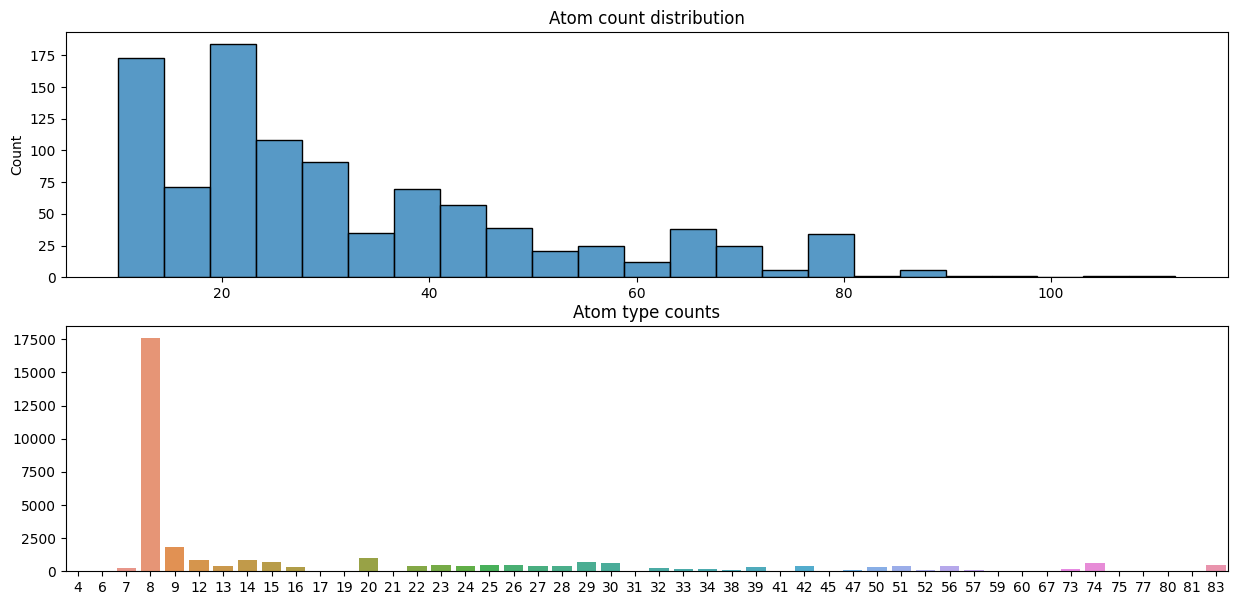

In [69]:
node_types = np.concatenate([g.ndata['node_type'] for g in graphs])
num_nodes = np.array([g.num_nodes() for g in graphs])
unique_node_types,counts = np.unique(node_types,return_counts=True)

fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(15,7)
ax1.title.set_text('Atom count distribution')
sns.histplot(num_nodes,ax=ax1)
ax2.title.set_text('Atom type counts')
sns.barplot(x=unique_node_types,y=counts,ax=ax2)
plt.show()

In [84]:
num_node_types = 95 # 92 elements of the periodic table + a special type for masked nodes
node_embed_dim = 16
edge_embed_dim = 100
edge_dims = [64,64] 
attn_dims = [16,32]
attn_heads = [8,8]
classifier_attn_heads = 8

model_MP = MyEGATClassifier(num_node_types,node_embed_dim,edge_embed_dim,edge_dims,attn_dims,attn_heads,classifier_attn_heads).to('cuda')
model_MP.load_state_dict(torch.load('MP-best.pt')['model'])


<All keys matched successfully>

In [187]:
model = model_MP.to('cuda')
preds = []
labels = []
transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

dataset = MyDataset(graphs)
loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

with torch.no_grad():
    for g in tqdm(loader): 
        g= g.to('cuda')
        efeats = g.edata['bond_dist_exp'].to('cuda')
        node_types = g.ndata['node_type'].to('cuda')
        nfeats,mask = mask_labels(node_types)

        logits,attns = compute_attentions(model,g,nfeats,efeats)
        preds.append(logits.argmax(dim=1)[mask].cpu().numpy())
        labels.append(node_types[mask].cpu().numpy())

preds = np.concatenate(preds,axis = 0)
labels = np.concatenate(labels)

  0%|          | 0/34 [00:00<?, ?it/s]

accuracy: 0.9600873090115373
f1_score:
	Be: 1.0
	C: 1.0
	N: 1.0
	O: 1.0
	F: 0.9985693848354792
	Mg: 0.8459383753501402
	Al: 0.7500000000000001
	Si: 0.9968454258675079
	P: 1.0
	S: 1.0
	Cl: 1.0
	K: 1.0
	Ca: 0.9151670951156813
	Ti: 0.881578947368421
	V: 0.9090909090909091
	Cr: 0.9079754601226994
	Mn: 0.8804347826086957
	Fe: 0.8670520231213872
	Co: 0.8874172185430463
	Ni: 0.8666666666666666
	Cu: 0.8988764044943819
	Zn: 0.8243243243243243
	Ga: 0.8
	Ge: 0.9787234042553191
	As: 0.8888888888888888
	Se: 0.9787234042553191
	Sr: 0.0
	Y: 0.8461538461538461
	Nb: 0.8421052631578947
	Mo: 0.8421052631578948
	Rh: 0.961038961038961
	Ag: 1.0
	Sn: 0.8333333333333333
	Sb: 0.8543689320388349
	Te: 0.8676470588235295
	Ba: 0.8163265306122449
	La: 0.9139072847682119
	Pr: 0.9473684210526316
	Ho: 0.7499999999999999
	Ta: 0.0
	W: 0.0
	Re: 0.0
	Ir: 1.0
	Tl: 0.8695652173913043
	Bi: 0.8823529411764707
	avg(macro): 0.7934865375766824
	avg(weighted): 0.9599167405091747

Labels counts: Be:6,  C:1,  N:48,  O:3576,  F:350,

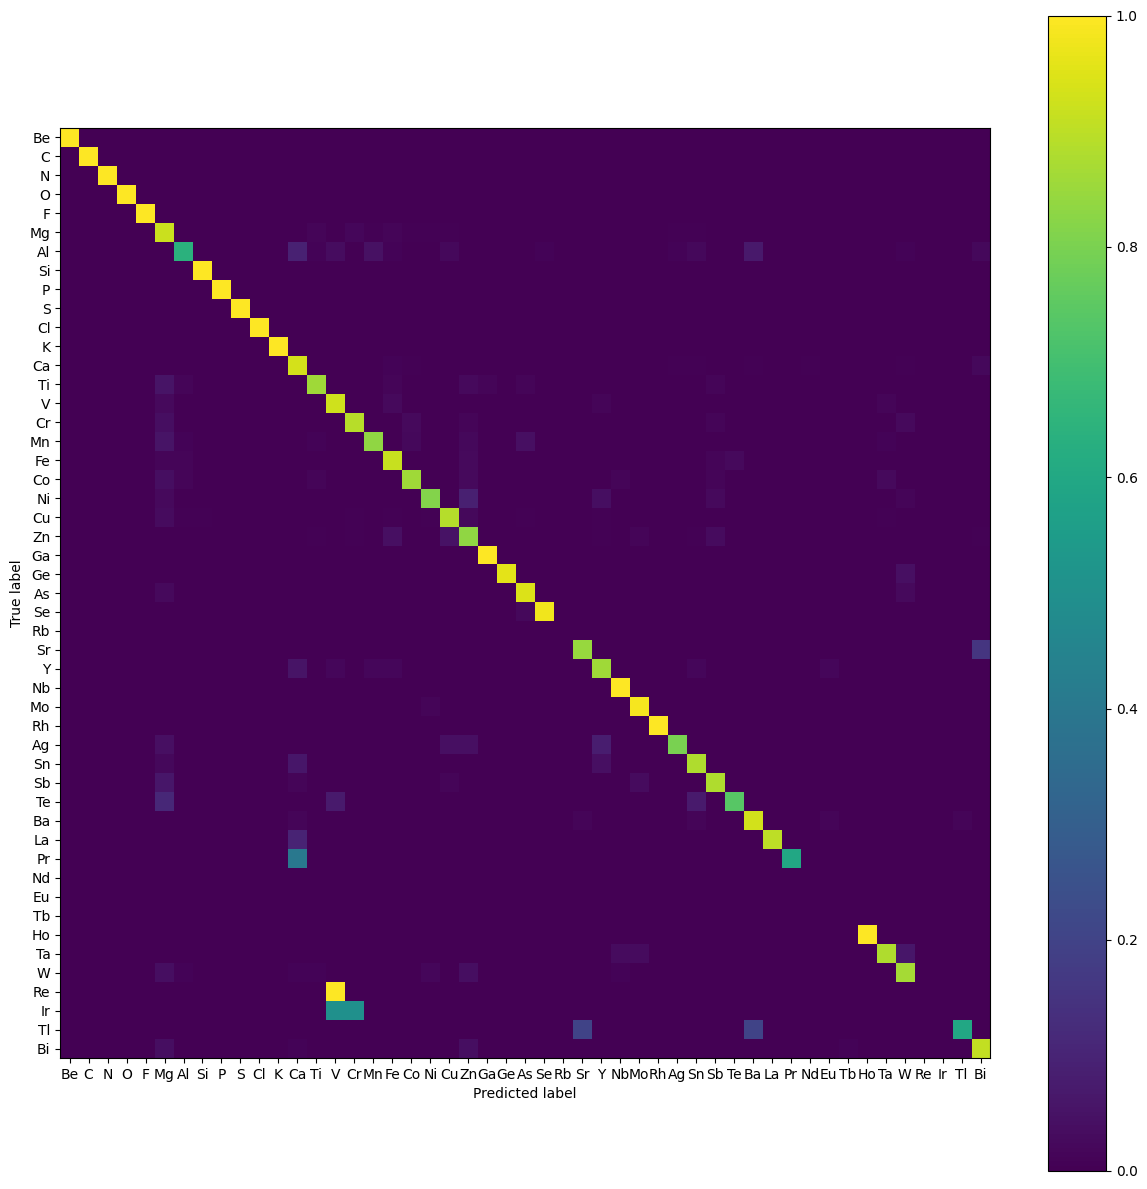

In [188]:
label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels,preds)))} 
accuracy_report(labels,preds)
plot_confusion_matrix(labels,preds,label_mappings,figsize=(15,15),normalize='true')

In [191]:
idx = np.random.randint(len(graphs))
g = graphs[idx]
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

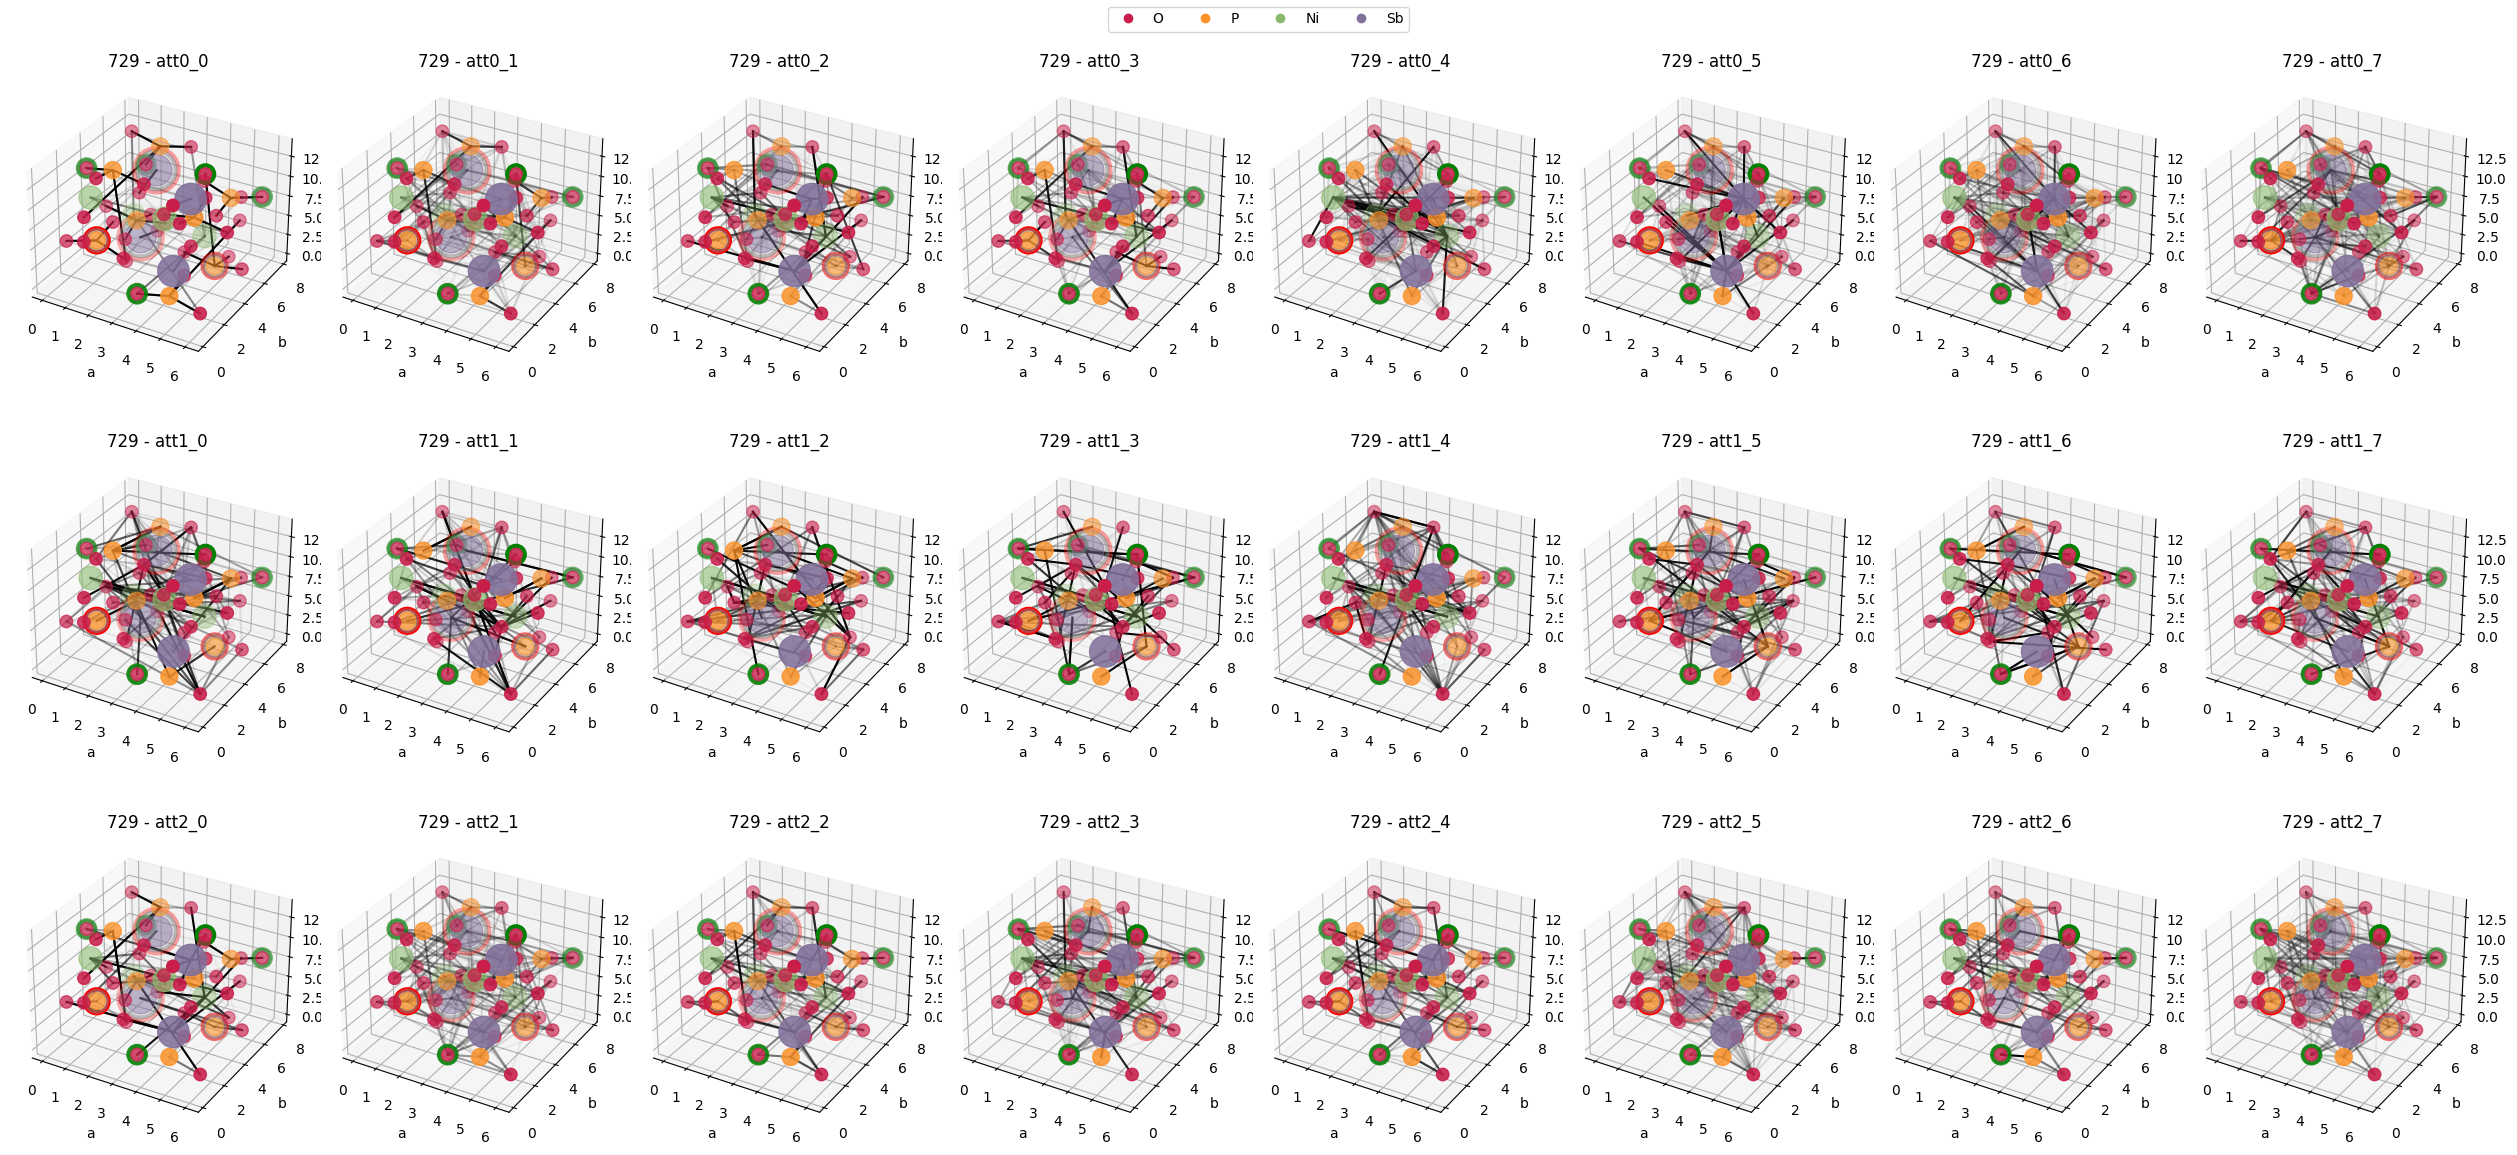

In [192]:
# GRAFO BELLISSIMO STA IN 31323
model = model.to('cpu')
g = g.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = transform(g.edata['bond_dist'])
    logits,attns = compute_attentions(model,g,nfeats,efeats)

if INTERACTIVE:
    display_selector(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))
else: 
    display_attn_grid(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))


In [74]:
del graphs, target_dict

## QM9 Exploration

In [75]:
graphs,target_dict = dgl.load_graphs('../data/QM9_graphs_simple.bin')
dataset = MyDataset(graphs)

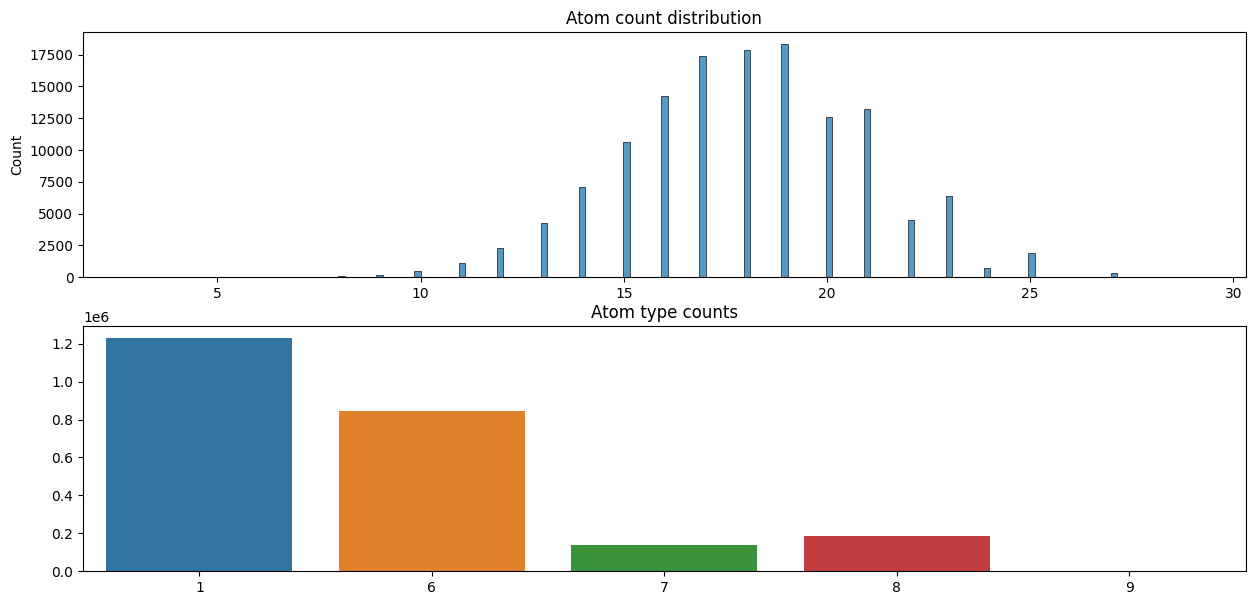

In [76]:
node_types = np.concatenate([g.ndata['node_type'] for g in graphs])
num_nodes = np.array([g.num_nodes() for g in graphs])
unique_node_types,counts = np.unique(node_types,return_counts=True)

fig,(ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(15,7)
ax1.title.set_text('Atom count distribution')
sns.histplot(num_nodes,ax=ax1)
ax2.title.set_text('Atom type counts')
sns.barplot(x=unique_node_types,y=counts,ax=ax2)
plt.show()

### Try some inference on a trained model

In [77]:
num_node_types = 93 # 92 elements of the periodic table + a special type for masked nodes
node_embed_dim = 16
edge_embed_dim = 100
edge_dims = [64,64] 
attn_dims = [16,32]
attn_heads = [8,8]
classifier_attn_heads = 8

model_QM9 = MyEGATClassifier(num_node_types,node_embed_dim,edge_embed_dim,edge_dims,attn_dims,attn_heads,classifier_attn_heads).to('cuda')
model_QM9.load_state_dict(torch.load('QM9-best.pt')['model'])

<All keys matched successfully>

In [78]:
model = model_QM9.to('cuda')
preds = []
labels = []
transform = GaussianExpansion(initial=0,final=6,num_centers=100,width=0.5)

dataset = MyDataset(graphs[:10000])
loader =  dgl.dataloading.GraphDataLoader(dataset,batch_size=30)

with torch.no_grad():
    for g in tqdm(loader): 
        efeats = transform(g.edata['bond_dist']).to('cuda')
        g= g.to('cuda')
        node_types = g.ndata['node_type'].to('cuda')
        nfeats,mask = mask_labels(node_types)


        logits,attns = compute_attentions(model,g,nfeats,efeats)
        preds.append(logits.argmax(dim=1)[mask].cpu().numpy())
        labels.append(node_types[mask].cpu().numpy())

preds = np.concatenate(preds,axis = 0)
labels = np.concatenate(labels)

  0%|          | 0/334 [00:00<?, ?it/s]

accuracy: 0.9103612923762534
f1_score:
	H: 0.995253742241694
	C: 0.9091147540983606
	N: 0.0
	O: 0.7246661429693637
	F: 0.0
	avg(macro): 0.5258069278618838
	avg(weighted): 0.880884380873566

Labels counts: H:16357,  C:10449,  N:1976,  O:2614,  F:19
Prediction counts: H:16511,  C:12426,  O:2478


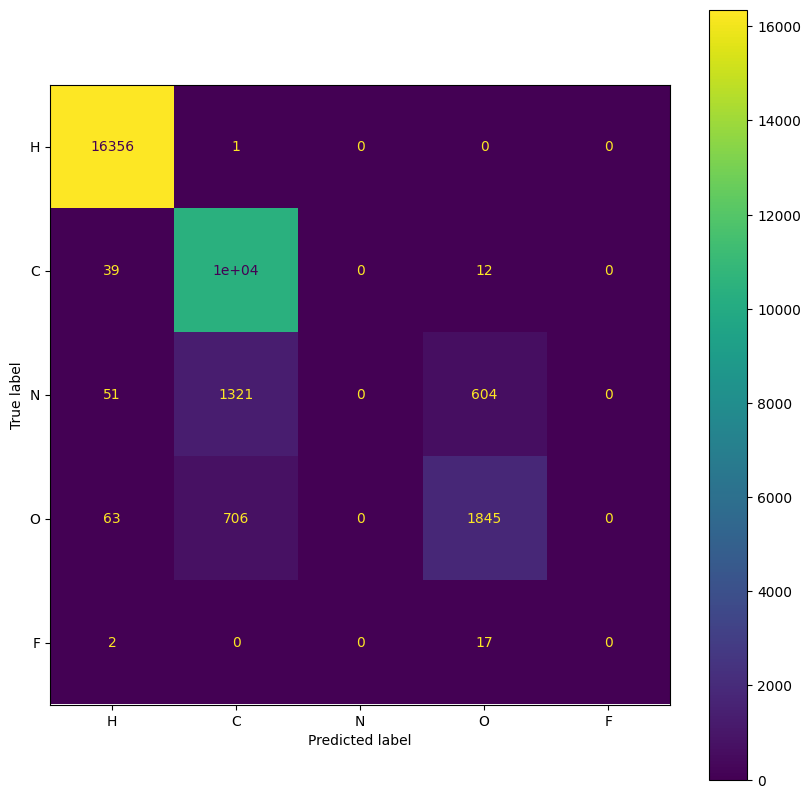

In [79]:
label_mappings = {l:mg.Element.from_Z(l).name for l in np.unique(np.concatenate((labels,preds)))} 
accuracy_report(labels,preds)
plot_confusion_matrix(labels,preds,label_mappings,figsize=(10,10),normalize = None)

In [178]:
idx = np.random.randint(len(graphs))
g = graphs[idx].to('cpu') 
getView(g).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

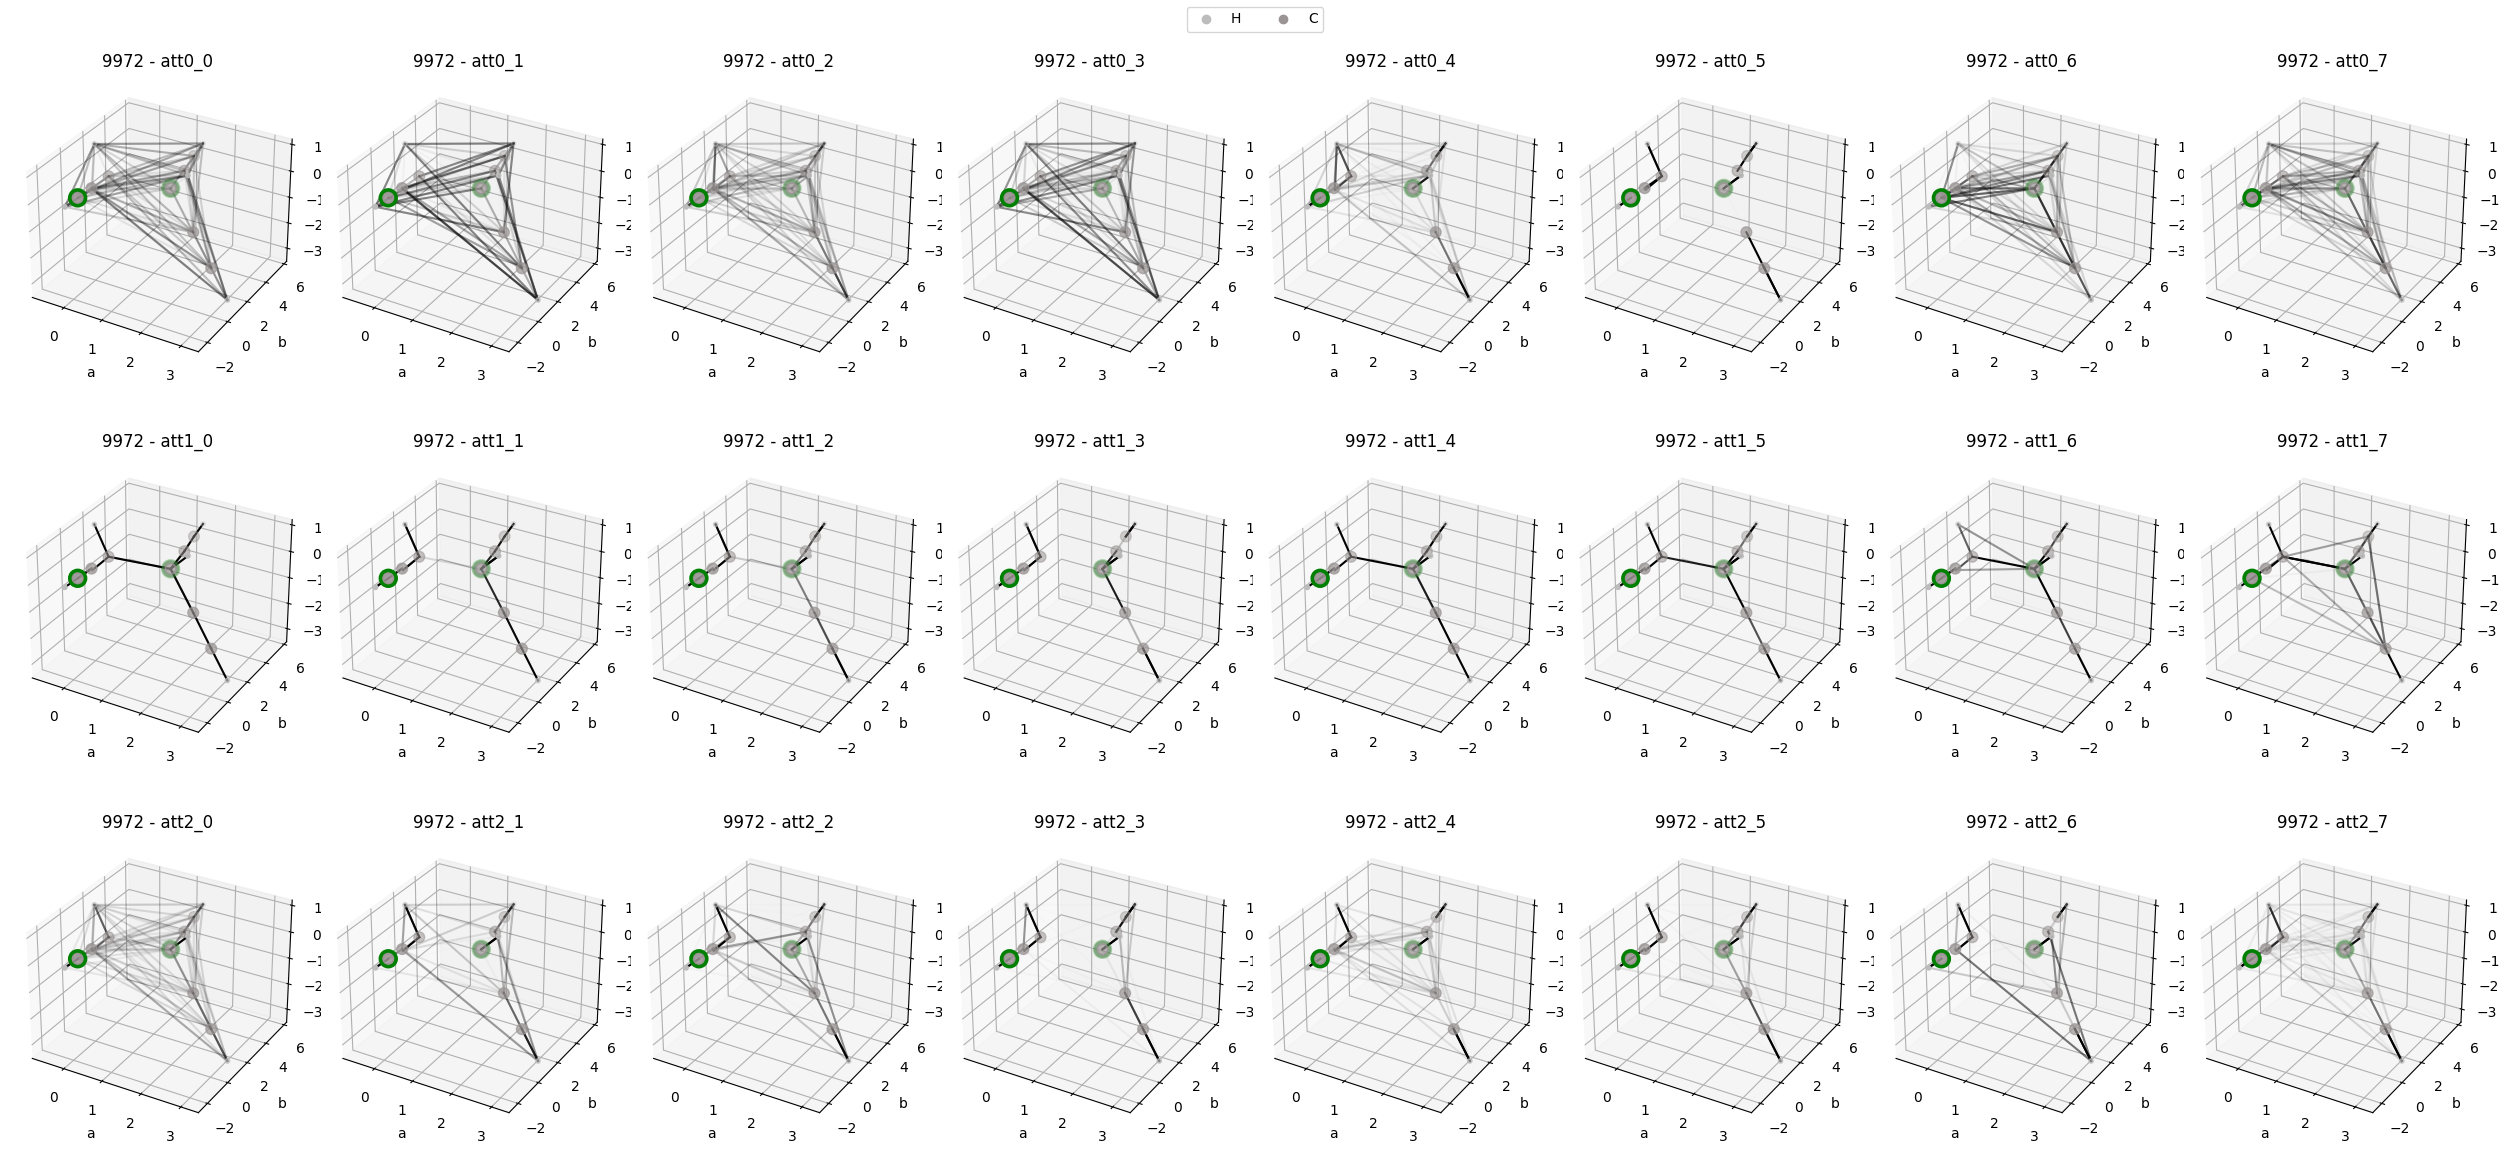

In [184]:
model = model_QM9.to('cpu')
with torch.no_grad():
    node_types = g.ndata['node_type']
    nfeats,mask = mask_labels(node_types)
    efeats = transform(g.edata['bond_dist'])
    logits,attns = compute_attentions(model,g,nfeats,efeats)

preds = logits.argmax(dim=1)

if INTERACTIVE: 
    display_selector(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))
    
else:
    display_attn_grid(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))

Try to infer on the same molecule but using the MP model

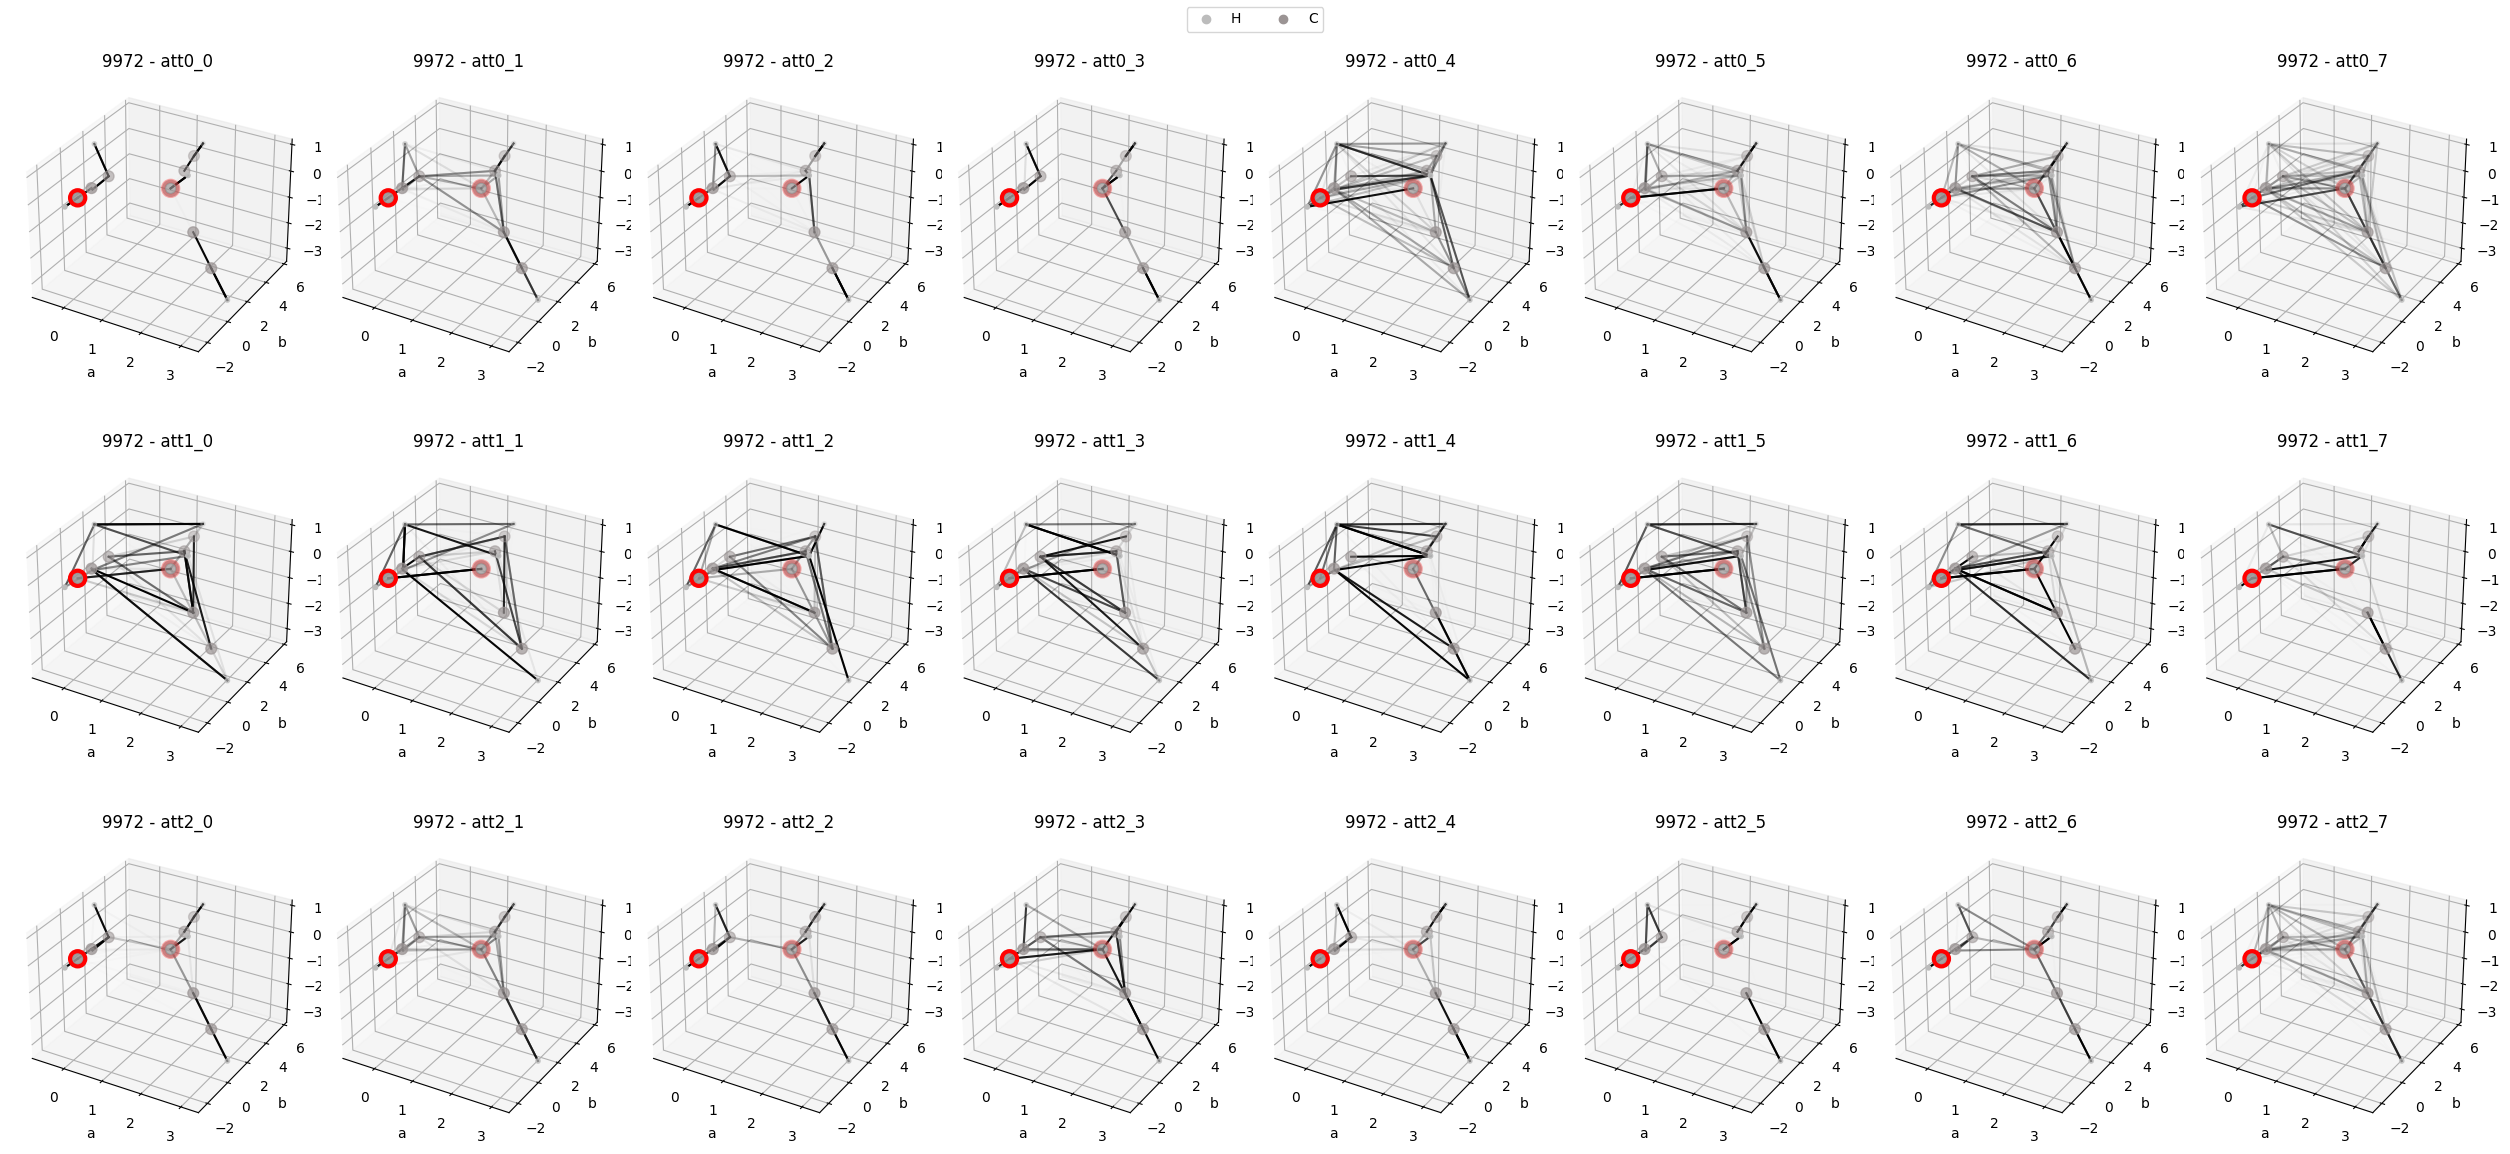

In [185]:
model = model_MP.to('cpu')
with torch.no_grad():
    logits,attns = compute_attentions(model,g,nfeats,efeats)

preds = logits.argmax(dim=1)

if INTERACTIVE: 
    display_selector(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))
    
else:
    display_attn_grid(g,attns,f'{target_dict["graphs_ids"][idx]}',mask,logits.argmax(dim=1))